In [1]:
import numpy as np
import pandas as pd

from code.AlgorithmComp_class import AlgorithmComp

In [2]:
ran_var = False
ran_int = True
n_fix = 1
a_type = 'alpha' # set 't' or 'alpha'
tol = 0.01
model = 'P'  # set 'B' or 'P'
n = 100
sim = True

AC = AlgorithmComp(ran_var, ran_int, n_fix, sim, tol, model, fix=None, lengths=None, y=None, N=None, t=None)

In [3]:
AC.N

10

In [4]:
AC.int_values

array([ 2.5,  1. , -1. ])

In [5]:
AC.y

[array([13., 19., 11.,  8.,  7., 24., 11.,  4.,  9.,  4., 11.,  7., 16.,
        17.,  5., 17.,  9., 11., 10., 14., 31., 10.,  9., 12., 16., 11.,
        13.,  4.,  9., 24., 13.,  7., 10., 22., 15., 11., 12., 23.,  7.,
        13.,  7., 13., 15., 11., 15., 26., 11., 30., 21., 10.,  5.,  9.,
        11., 13.,  8.,  7., 19., 16., 16.,  9.,  4., 24., 15., 15.,  9.,
         8., 10., 18.,  5.,  6., 18., 10., 13.,  8.]),
 array([13.,  7., 16., 18., 11., 11., 13., 12.,  9.,  3., 19., 11., 18.,
         7., 18., 10.,  7.,  5.,  7.,  8., 14., 14.,  7., 20.,  9.,  4.,
        13.,  5., 20., 19., 14., 10., 18., 11., 24., 19., 11., 16., 18.,
        25., 21., 14., 16., 21., 20., 16., 18.,  8., 19., 11., 18.,  8.,
         4.,  8., 11., 16., 15., 16., 19., 11.,  7.,  7., 17., 16.,  9.,
        13., 14., 15., 12., 11.,  6.,  9., 10.]),
 array([5., 1., 2., 4., 1., 1., 3., 2., 2., 3., 2., 3., 3., 1., 1., 2., 2.,
        4., 2., 2., 5., 0., 1., 1., 4., 0., 1., 5., 2., 3., 1., 1., 0., 3.,
        5., 2

In [6]:
from cmdstanpy import cmdstan_path
cmdstan_path()

# Create folder to store .stan files
import os
if not os.path.exists("./code/stan"):
    os.mkdir("./code/stan")

# Import modules
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [7]:
stan_model_code = """
data {
    int<lower=1> Ntot;
    int<lower=1> Ngroups;
    int<lower=1> x_size;
    int<lower=1> z_size;
    int<lower=1> M_max;
    real<lower=0> alpha; // Typically 1 / M_max

    array[Ntot] int<lower=0> y;              // Updated to new array syntax
    array[Ngroups] int<lower=1> group_sizes; // Updated to new array syntax

    matrix[Ntot, x_size] X;
    matrix[Ntot, z_size] Z;
}

parameters {
    array[M_max] vector[z_size] b; // Changed to array syntax for compatibility
    vector[x_size] regressors;
    simplex[M_max] omega;
}

transformed parameters {
    vector[Ntot] fixed_means;
    for (i in 1:Ntot) {
        fixed_means[i] = dot_product(X[i, :], regressors);
    }
}

model {
    omega ~ dirichlet(rep_vector(1, M_max) * alpha);
    b ~ multi_normal_cholesky(rep_vector(0, z_size), diag_matrix(rep_vector(1, z_size)));
    regressors ~ normal(0, 1);

    int j = 1; // Initialize j before looping over groups
    for (i in 1:Ngroups) {
        vector[M_max] log_probas = log(omega);
        for (k in 1:group_sizes[i]) {
            for (m in 1:M_max) {
                real rate = exp(fixed_means[j] + dot_product(Z[j, :], b[m]));
                log_probas[m] += poisson_lpmf(y[j] | rate);
            }
            j += 1;
        }
        target += log_sum_exp(log_probas);
    }
}

generated quantities {
    vector[Ngroups] clus_allocs;
    int j = 1;

    for (i in 1:Ngroups) {
        vector[M_max] log_probas = log(omega);
        for (k in 1:group_sizes[i]) {
            for (m in 1:M_max) {
                real rate = exp(fixed_means[j] + dot_product(Z[j, :], b[m]));
                log_probas[m] += poisson_lpmf(y[j] | rate);
            }
            j += 1;
        }
        clus_allocs[i] = categorical_rng(softmax(log_probas));
    }
}

"""

In [8]:
# Write model to file
stan_file = "./code/stan/mymodel.stan"
with open(stan_file, "w") as f:
    print(stan_model_code, file=f)

In [9]:
# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

12:27:34 - cmdstanpy - INFO - compiling stan file /Users/alessandragni/Documents/DATA/POLITECNICO/PHD/CODE_REPO/glmmDREclust/code/stan/mymodel.stan to exe file /Users/alessandragni/Documents/DATA/POLITECNICO/PHD/CODE_REPO/glmmDREclust/code/stan/mymodel
12:27:44 - cmdstanpy - INFO - compiled model executable: /Users/alessandragni/Documents/DATA/POLITECNICO/PHD/CODE_REPO/glmmDREclust/code/stan/mymodel


In [10]:
# Flatten each key's arrays into a single column, then find the maximum length
columns = {}
max_length = 0
for key, arrays in AC.fix.items():
    # Concatenate arrays under each key into a single 1D array
    combined_array = np.concatenate(arrays)
    columns[key] = combined_array
    # Update maximum length
    max_length = max(max_length, len(combined_array))

# Pad each column to ensure equal length using np.nan for missing values
padded_columns = []
for key in sorted(columns.keys()):  # Sort keys to keep order consistent
    column = np.pad(columns[key], (0, max_length - len(columns[key])), constant_values=np.nan)
    padded_columns.append(column)

# Stack columns horizontally to form the final matrix
X = np.column_stack(padded_columns)

print(X)

[[ 1.31578e+00]
 [ 1.51349e+00]
 [-1.02699e-01]
 [-5.64437e-01]
 [ 3.21942e-02]
 [ 1.97937e+00]
 [-1.71888e+00]
 [-5.80338e-01]
 [-1.09236e+00]
 [-1.05085e+00]
 [ 3.03630e-01]
 [ 3.45412e-01]
 [ 5.67435e-01]
 [ 4.45280e-01]
 [-1.83485e+00]
 [-4.59364e-01]
 [-3.41765e-01]
 [-7.25481e-01]
 [-1.76992e+00]
 [-2.18965e-01]
 [ 2.13741e+00]
 [-3.40954e-01]
 [-9.94410e-01]
 [-1.89713e+00]
 [ 5.11537e-01]
 [-6.59176e-01]
 [ 2.27865e-01]
 [-1.25049e+00]
 [ 7.02802e-01]
 [ 1.72731e+00]
 [-2.21836e-02]
 [-1.57962e+00]
 [-1.11169e+00]
 [ 1.50468e+00]
 [ 3.40155e-01]
 [ 2.98203e-01]
 [-5.82395e-01]
 [ 1.36501e+00]
 [-7.71028e-01]
 [ 3.60202e-01]
 [-9.68536e-01]
 [-1.11836e+00]
 [ 7.54207e-01]
 [-4.03962e-02]
 [-2.27067e-02]
 [ 2.00690e+00]
 [-1.08218e+00]
 [ 2.85646e+00]
 [ 7.41170e-01]
 [ 7.50051e-01]
 [-1.25165e+00]
 [ 2.76470e-01]
 [-4.07249e-01]
 [-1.11741e+00]
 [ 1.20363e-01]
 [-1.74927e+00]
 [ 1.87779e+00]
 [ 4.64390e-01]
 [ 1.35047e+00]
 [-3.83120e-01]
 [-1.42835e+00]
 [ 2.17544e+00]
 [ 9.388

In [11]:
Z = np.ones((sum(AC.lengths), 1))

In [12]:
Ntot = sum(AC.lengths)
Ngroups = M_max = AC.N
x_size = len(AC.fix_var_values)
z_size = ran_int + ran_var
alpha = 1/M_max
y = np.array(np.concatenate(AC.y), dtype=int)
group_sizes = AC.lengths


# Prepare data list for stan
my_data = {
    "Ntot": Ntot,
    "Ngroups": Ngroups,
    "x_size": x_size,
    "z_size": z_size,
    "M_max": M_max,

    "alpha" : alpha,

    "y": y,
    "group_sizes": group_sizes,

    "X": X,
    "Z": Z
}

In [13]:
# Run the sampler
stan_fit = stan_model.sample(data=my_data, chains=4, parallel_chains=4, 
                             iter_warmup=1000, iter_sampling=5000)

# Convert chain to arviz format
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

12:27:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:44:43 - cmdstanpy - INFO - CmdStan done processing.


12:44:44 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 202 divergent transitions (4.0%)
	Chain 1 had 130 iterations at max treedepth (2.6%)
	Chain 2 had 126 divergent transitions (2.5%)
	Chain 3 had 183 divergent transitions (3.7%)
	Chain 3 had 59 iterations at max treedepth (1.2%)
	Chain 4 had 142 divergent transitions (2.8%)
	Chain 4 had 82 iterations at max treedepth (1.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [14]:
import arviz as az

# Assuming cmdstanpy_data is the InferenceData object from the previous step

# 1. Get the posterior samples from the InferenceData object
posterior_samples = cmdstanpy_data.posterior

# 2. Extract specific parameters (e.g., 'b', 'regressors', and 'omega')
b_samples = posterior_samples['b']
regressors_samples = posterior_samples['regressors']
omega_samples = posterior_samples['omega']

In [15]:
stan_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-1449.060000,0.049513,3.62538,-1455.53000,-1448.720000,-1443.76000,5361.210,1.819890,1.00066
"b[1,1]",0.255149,0.094513,1.22661,-1.45222,0.213812,2.49639,168.433,0.057176,1.02026
"b[2,1]",0.099022,0.055460,1.11285,-1.43211,0.051865,2.46305,402.632,0.136676,1.01045
"b[3,1]",0.160617,0.073586,1.15549,-1.44424,0.128691,2.48062,246.569,0.083699,1.01239
"b[4,1]",0.233969,0.086509,1.20617,-1.40042,0.175529,2.49496,194.399,0.065990,1.01551
...,...,...,...,...,...,...,...,...,...
clus_allocs[7],5.612100,0.056322,2.89514,1.00000,6.000000,10.00000,2642.300,0.896946,1.00337
clus_allocs[8],5.399150,0.045519,2.87747,1.00000,5.000000,10.00000,3996.020,1.356470,1.00086
clus_allocs[9],5.408050,0.046227,2.87928,1.00000,5.000000,10.00000,3879.420,1.316890,1.00079
clus_allocs[10],5.402800,0.045680,2.87294,1.00000,5.000000,10.00000,3955.500,1.342720,1.00085


In [16]:
clus_allocs_summary = az.summary(stan_fit, var_names=['clus_allocs'])

# Print the summary
print(clus_allocs_summary)

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
clus_allocs[0]  5.556  2.672     1.0      9.0      0.653    0.534      19.0   
clus_allocs[1]  5.556  2.672     1.0      9.0      0.654    0.534      19.0   
clus_allocs[2]  5.614  2.907     1.0     10.0      0.056    0.040    2868.0   
clus_allocs[3]  5.607  2.899     1.0     10.0      0.057    0.042    2661.0   
clus_allocs[4]  5.599  2.895     1.0     10.0      0.056    0.041    2762.0   
clus_allocs[5]  5.610  2.898     1.0     10.0      0.057    0.042    2716.0   
clus_allocs[6]  5.612  2.895     1.0     10.0      0.056    0.041    2765.0   
clus_allocs[7]  5.399  2.877     1.0     10.0      0.046    0.032    4121.0   
clus_allocs[8]  5.408  2.879     1.0     10.0      0.046    0.033    4108.0   
clus_allocs[9]  5.403  2.873     1.0     10.0      0.046    0.032    4166.0   

                ess_tail  r_hat  
clus_allocs[0]      71.0   1.45  
clus_allocs[1]      71.0   1.45  
clus_allocs[2]    3053.0   1

/Users/alessandragni/Library/Python/3.9/lib/python/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


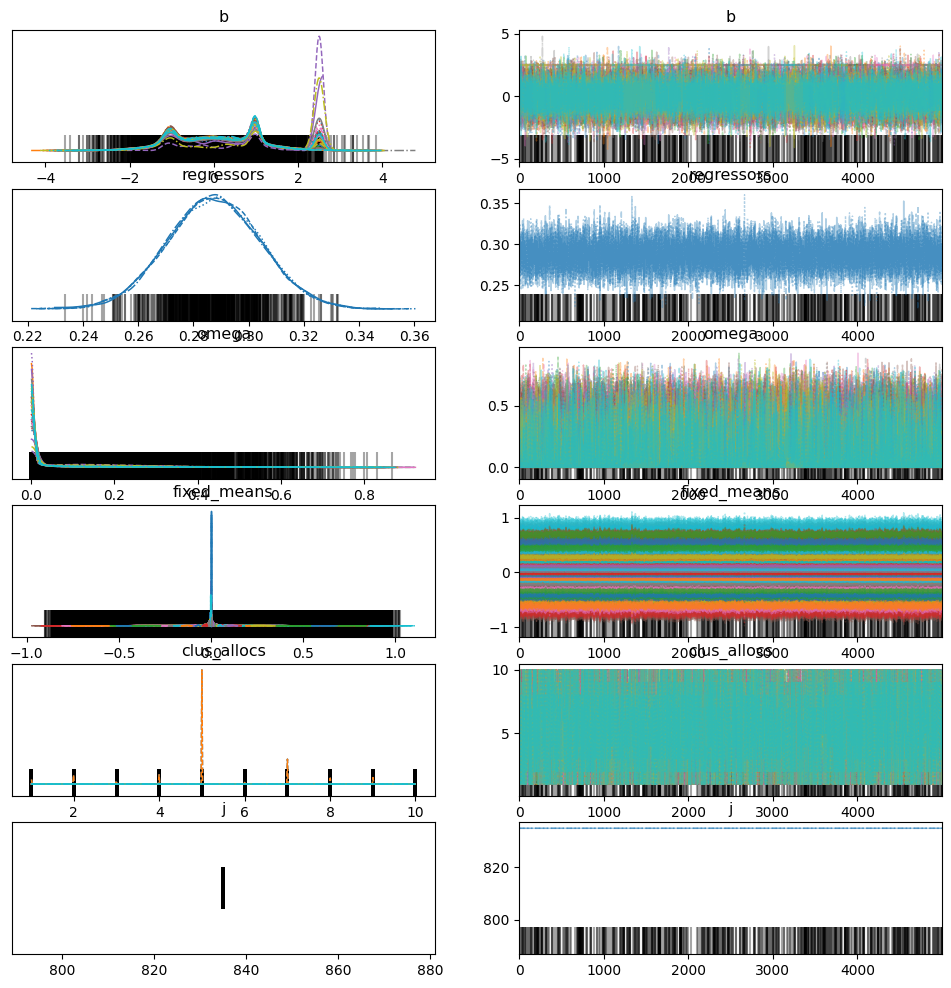

In [17]:
# Some plot using arviz
az.plot_trace(cmdstanpy_data)
plt.show()

/Users/alessandragni/Library/Python/3.9/lib/python/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (866), generating only 20 plots
  warnings.warn(


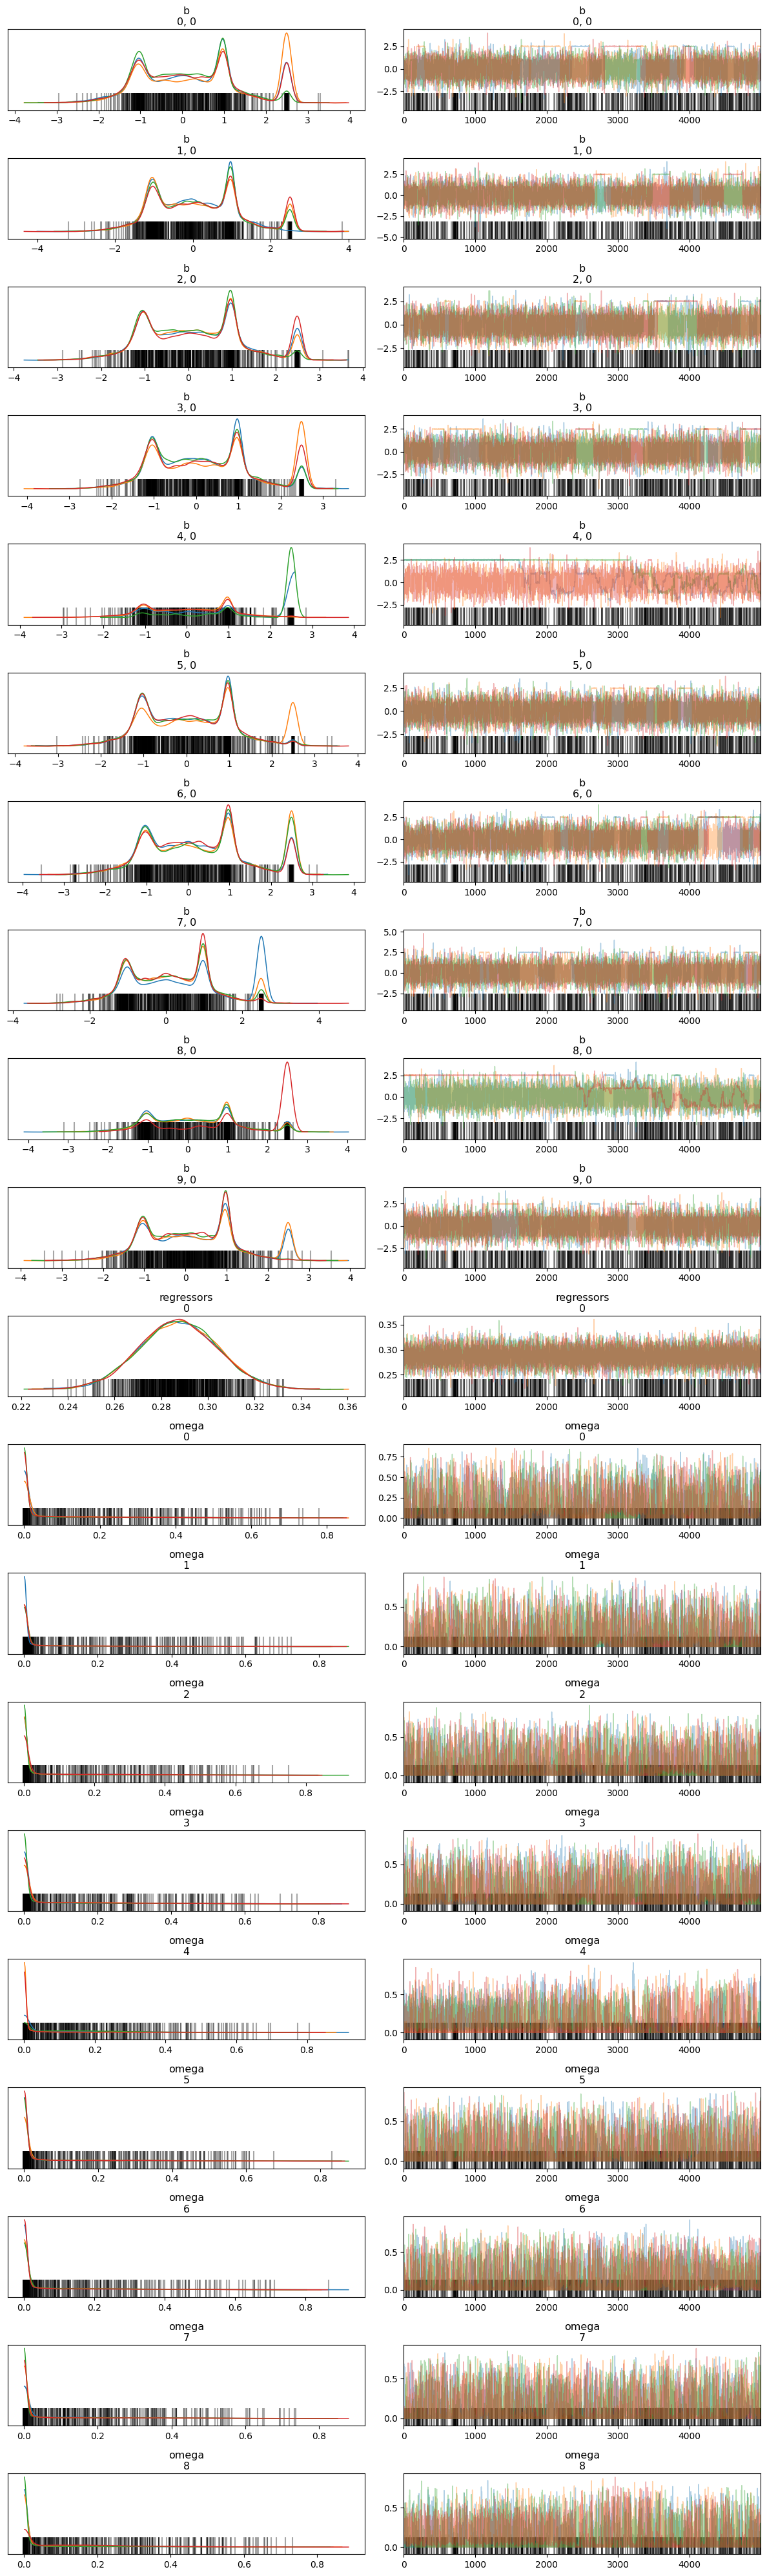

In [18]:
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
plt.show()